In [5]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "www.india.gov.in"
full_url = "https://www.india.gov.in/"

In [6]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [7]:
import pandas as pd

# Create a list to store the text files
texts=[]

#scraped_file_name
domain_underscored = domain.replace('.', '_')
SCRAPED_FILENAME = 'scraped_'+domain+'.csv'
EMBEDDINGS_FILENAME = 'embeddings_'+domain+'.csv'

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding='utf-8') as f:
        text = f.read()

        # Omit the first 75 lines and the last 3 lines, then replace -, _, and #update with spaces.
        texts.append((file[75:-3].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/' + SCRAPED_FILENAME)
df.head()

C:\Users\saura\AppData\Local\Temp\ipykernel_32512\2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,,. National Portal of India Ski...
1,,. National Portal of India Ski...
2,,. Page Unavailable Page Unavailable The page...
3,,. Acts and Rules by Department of School Ed...
4,logy.,logy.. Page Unavailable Page Unavailable The...


<AxesSubplot: >

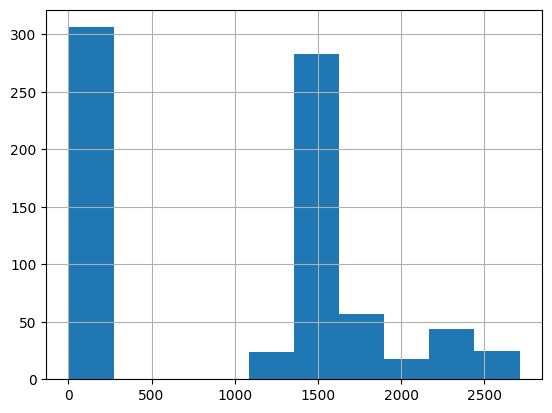

In [8]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/' + SCRAPED_FILENAME, index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [9]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

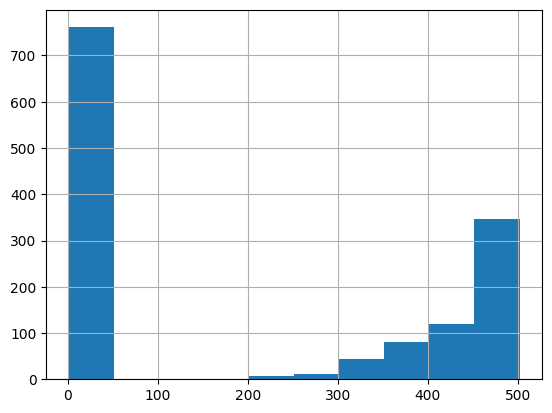

In [10]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [11]:
import openai
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
) # for exponential backoff

@retry(wait=wait_random_exponential(min=30, max=90), stop=stop_after_attempt(10))
def embedding_with_backoff(**kwargs):
    return openai.Embedding.create(**kwargs)

openai.api_key_path='C:\Projects\openai-cookbook\openai_api_key.secret'
df['embeddings'] = df.text.apply(lambda x: embedding_with_backoff(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/' + EMBEDDINGS_FILENAME)
df.head()

,text,n_tokens,embeddings
0,.,1,"[-0.00875202938914299, -0.016862068325281143, ..."
1,Governors & Administrators-- Chief Ministers--...,494,"[0.0038678464479744434, 0.005229910835623741, ..."
2,.,1,"[-0.008706624619662762, -0.01683630421757698, ..."
3,Governors & Administrators-- Chief Ministers--...,494,"[0.003913219552487135, 0.005275394301861525, -..."
4,. Page Unavailable Page Unavailable The page...,39,"[-0.017538020387291908, -0.005951302126049995,..."


In [12]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/' + EMBEDDINGS_FILENAME, index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,.,1,"[-0.00875202938914299, -0.016862068325281143, ..."
1,Governors & Administrators-- Chief Ministers--...,494,"[0.0038678464479744434, 0.005229910835623741, ..."
2,.,1,"[-0.008706624619662762, -0.01683630421757698, ..."
3,Governors & Administrators-- Chief Ministers--...,494,"[0.003913219552487135, 0.005275394301861525, -..."
4,. Page Unavailable Page Unavailable The page...,39,"[-0.017538020387291908, -0.005951302126049995,..."


In [21]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=2000,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't ajskhdnbknow \"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [22]:
answer_question(df, question="What day is it?", debug=False)

This model's maximum context length is 4097 tokens, however you requested 4201 tokens (2201 in your prompt; 2000 for the completion). Please reduce your prompt; or completion length.


''

In [23]:
answer_question(df, question="What is our newest embeddings model?")

This model's maximum context length is 4097 tokens, however you requested 4205 tokens (2205 in your prompt; 2000 for the completion). Please reduce your prompt; or completion length.


''

In [24]:
answer_question(df, question="Give me a description of what OpenAI does.")

This model's maximum context length is 4097 tokens, however you requested 4208 tokens (2208 in your prompt; 2000 for the completion). Please reduce your prompt; or completion length.


''

In [25]:
answer_question(df, question="Tell me something about Manipur.")

'Manipur is a state in India. The Manipur State Information Technology Society (MSITS) is under the administrative control of Department of Information Technology, Govt. of Manipur and is the State Designated Agency/Implementing Agency for all National e-Governance Plan (NeGP) projects in the State. There are tourist places in the districts of Thoubal, Imphal East, Imphal West, and Tamenglong. The Information Technology Department is implementing all IT related Project/Schemes, including e-Governance in the State. Ranjan Singh Rajkumar is a Member of Parliament from the Bharatiya Janata Party representing the Inner Manipur constituency.'

In [26]:
answer_question(df, question="What is the Manipur State Information Technology Society?")

'The Manipur State Information Technology Society (MSITS) is under the administrative control of Department of Information Technology, Govt. of Manipur and is the State Designated Agency/Implementing Agency for all National e-Governance Plan (NeGP) projects in the State.'

In [27]:
answer_question(df, question="What are some of the best initiatives of the government of India?")

'Some of the best initiatives of the government of India include the Scheme of Stand Up India in Business Activity Loan, the Swavalamban - the Co-contributory Pension Scheme, the National Rural Livelihoods Mission, the Pradhan Mantri Gram Sadak Yojana, and the Prime Minister Rural Development Fellows Scheme.'

In [28]:
answer_question(df, question="What is the Swavalamban - the Co-contributory Pension Scheme?")

'Swavalamban - the Co-contributory Pension Scheme by Department of Financial Services aims to encourage people from the unorganised sector to voluntarily save for their retirement and to lower the cost of operations of the New Pension System (NPS).'

In [29]:
answer_question(df, question="When was Swavalamban scheme launched?")

'Swavalamban - the Co-contributory Pension Scheme was launched by Department of Financial Services in 2010.'

In [30]:
answer_question(df, question="Tell me more about the Pradhan Mantri Gram Sadak Yojana")

'Get guidelines for National Quality Monitors (NQMs) to monitor quality of road works by Pradhan Mantri Gram Sadak Yojana (PMGSY), Ministry of Rural Development. Users can access information about NQMs, arrangements for inspection, preparation for inspection, post inspection, preparation of inspection report, etc.'